# 📊 Hierarchical selection function for a subset of the Gaia catalogue

The GaiaUnlimited module **subsample** provides a simple way of counting sources satisfying user-defined criteria, out of the whole Gaia catalogue. The result is given per bin of magnitude and/or colour, and per healpix region on the sky. The colour and magnitude binning can be chosen by the user, as well as the spatial resolution (order of the healpix tessellation).

Before going through this tutorial, the user is encouraged to familiarise themselves with the `SubsampleSelectionFunction` interface in the **Selection function for a subset of the Gaia catalogue** tutorial.

There are cases where there are no stars in a parent catalogue within certain pixels of the sky at certain magnitudes or colours. It is therefore not possible to estimate the completeness of the subsample under there particular conditions. This can happen if the required spatial resolution is too high. The same applies if the magnitude bins are too narrow and/or the magnitude values are too high or too low. One possible solution is to use the non-informative prior to estimate the completeness: the probability of fulfilling or not fulfilling the subsampling criteria is equal to 1/2 if no stars are observed. An alternative approach is to use information from the upper level(s) of the healpix hierarchy, i.e. from lower spatial resolution areas where there are better chances of getting a star. This is the idea of the hierarchical algorithm: we go up the healpix hierarchy until we meet at least one star. The maximum likelihood estimate (MLE) at that level is then distributed down the hierarchy.

This algorithm is implemented in `SubsampleSelectionFunctionHMLE` class. Here are possible use cases:

1. Use the same way as the `SubsampleSelectionFunction` class: the `subsample_query`, `file_name` and `hplevel_and_binning` values are passed to the constructor of the class. The data will be collected through the Gaia TAP+ interface then processed.
2. No parameters are passed to the constructor, an empty class instance is created. The data should be provided later by user and processed with the `use` method.
3. An instance of the `SubsampleSelectionFunction` class is passed to the `use` method. This assumes that the data has already been collected using the `SubsampleSelectionFunction` class.
4. `pandas.DataFrame` and `hplevel_and_binning` are passed to the function `use`.
5. `xarray.Dataset` and `hplevel_and_binning` are passed to the function `use`.

We will look at some of these cases below.

In either case, the constructor or the `use` function may be informed with the confidence level `z` which is the **(1-α/2)** quantile of a standard normal distribution (i.e. probit, see [Wiki](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)), and **α** is the confidence level:

- Confidence level = 95%   =>  error rate = 0.05  =>  z = 1.96
- Confidence level = 68%   =>  error rate = 0.32  =>  z = 0.99

Given the confidence level, the lower and the upper boundaries of the confidence interval are estimated.

The algorithm estimates the completeness of the subsample and its confidence interval (if the `z` is provided) at all healpix levels from zero (the upper) to any desired level.

## Use case 1

In [1]:
import os

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import healpy as hp
from astroquery.gaia import Gaia

import gaiaunlimited
from gaiaunlimited import fetch_utils,utils
from gaiaunlimited import subsample

In [2]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

# Optional: authenticate with your Gaia archive credentials
# so the result of the query are stored online.
#Gaia.login(user='username', password='passwd')

Define dependencies of the selection function:
    
* _[Required]_ `healpix`: desired resolution in the form of healpix level
* _[Optional]_ Gaia columns: 
    * `name_of_column`: [_minimum value_, _maximum value_, _bin size_]
    * ...

In this example we make bins of 0.2 mag in **phot_g_mean_mag** only. We want the result in healpix regions of order 6.

In [3]:
inDict = {'healpix': 6, 'phot_g_mean_mag': [1.5, 20, 0.5]}

Launch the query to the Gaia DR3 catalogue to determine which fraction of sources have a continuous XP spectrum (**has_xp_continuous**). This operation can take ~40 minutes.

The result will be stored locally in your **gaiaunlimited** folder (by default, `.gaiaunlimited` but may be overriden) as **dr3_xp_hpx6.csv**. If there is a file with the same name retrived from the same request, the module will read the local file instead of querying the Gaia archive. This can also take some time to complete.

In [4]:
# Just for example: store the collected data in the local directory
os.environ['GAIAUNLIMITED_DATADIR'] = './gaiaunlimited.data'

In [ ]:
%%time
subsampleSF_HMLE \
    = subsample.SubsampleSelectionFunctionHMLE(subsample_query='has_xp_continuous', \
                                               file_name='dr3_xp_hpx6', hplevel_and_binning=inDict, \
                                               z=1.96)

Now we want to visualise the results for the entire sky, so we generate a list of coordinates of the centers of all healpix regions of order 6.

For this plot we visualise the selection function at G=12.

The **.query()** method returns the posterior probability of a source satisfying the user-defined criteria, along with the associated confidence interval (its lower and upper boundaries), if the user needed it. We visualise both:

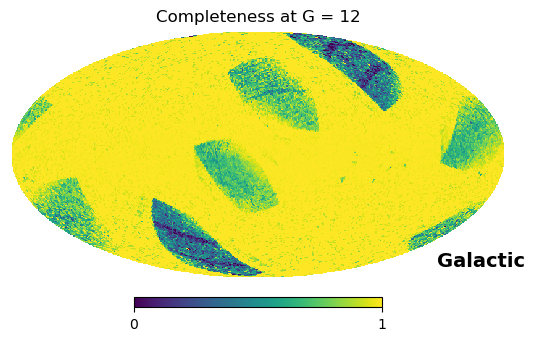

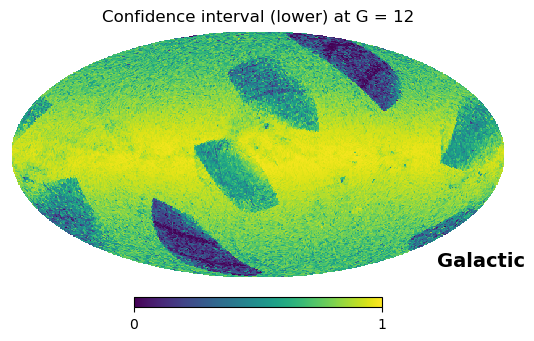

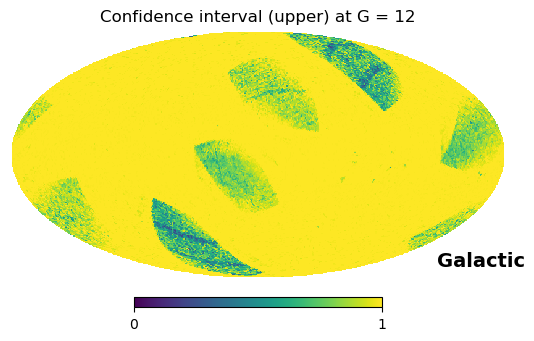

In [6]:
# Specify the healpix level
hplevel = 6
# Specify at which magnitude you want to visualise the selection fraction:
G = 12

coords_of_centers = utils.get_healpix_centers(hplevel)
gmag = np.ones_like(coords_of_centers) * G

# The `query` interface is completely resembles the one in the `SubsampleSelectionFunction` class,
# except the `return_confidence` parameter, replacing the parameter `return_variance` in the former implementation
p, ci_lo, ci_hi \
    = subsampleSF_HMLE.query(coords_of_centers, hplevel=hplevel, phot_g_mean_mag_=gmag, return_confidence=True)

plt.figure()
hp.mollview(p, hold=True, min=0, max=1, title="Completeness at G = {}".format(G), coord='CG')
plt.show()
plt.close()

plt.figure()
hp.mollview(ci_lo, hold=True, min=0, max=1, title="Confidence interval (lower) at G = {}".format(G), coord='CG')
plt.show()
plt.close()

plt.figure()
hp.mollview(ci_hi, hold=True, min=0, max=1, title="Confidence interval (upper) at G = {}".format(G), coord='CG')
plt.show()
plt.close()

## Use case 3

Here, we fetch the same data with the `SubsampleSelectionFunction` class, then pass it to the new class. Estimate the confidence interval at the 68% C.L.

In [ ]:
%%time
subsampleSF \
    = subsample.SubsampleSelectionFunction(subsample_query='has_xp_continuous', \
                                           file_name='dr3_xp_hpx6', hplevel_and_binning=inDict)

subsampleSF_HMLE = subsample.SubsampleSelectionFunctionHMLE().use(subsampleSF, z=0.99)

Let us dive into the internals of the `SubsampleSelectionFunctionHMLE` class. We can extract more interesting information using them.

The main product of the HMLE algorithm is the `hds` list. The _l_-th element of this list corresponds to the _l_-th level of the healpix hierarchy. Each element is a dataset (`xarray.Dataset`) that contains: the number of stars in the parent catalogue `'n'`, number of stars in the subsample `'k'`, logit of the probability of completeness `'logitp'`, and the boundaries of the confidence intervals `'ci_lo'` and `'ci_hi'` (if the confidence level `z` was provided before). These distributions are defined on the same healpixels (zeroth dimension) vs. magnitudes vs. whatever was requested (first and subsequent dimensions) grid.

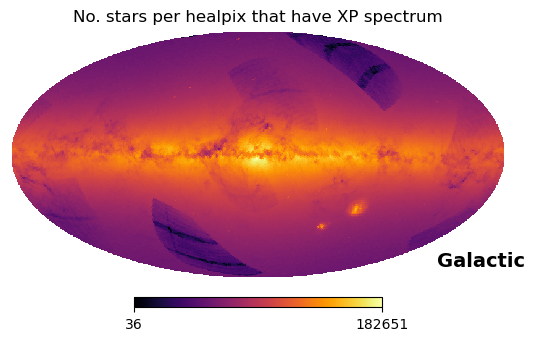

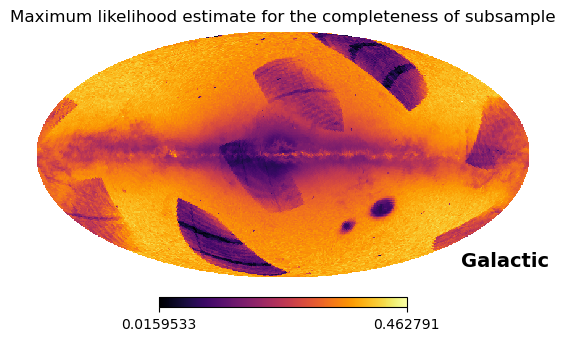

In [9]:
# Plot the sky maps off the `hds` list

hplevel = 6

# Collect the total number of sources inside every healpix, _regardless their magnitudes_ (the summation over the last axis is for that)
n = subsampleSF_HMLE.hds[hplevel]['n'].sum(axis=-1)
k = subsampleSF_HMLE.hds[hplevel]['k'].sum(axis=-1)

# We need to do this in order to harmonize the healpix enumeration scheme
ipix = utils.coord2healpix(coords_of_centers, 'icrs', nside=hp.order2nside(hplevel), nest=True)
n = n[ipix]
k = k[ipix]

plt.figure()
hp.mollview(k, hold=True, norm='log', cmap='inferno', title="No. stars per healpix that have XP spectrum", coord='CG')
plt.show()
plt.close()

plt.figure()
hp.mollview(k/n, hold=True, cmap='inferno', title="Maximum likelihood estimate for the completeness of subsample", coord='CG')
plt.show()
plt.close()

As seen, the integral distribution of the number of sources (i.e. summed up by the magnitudes) have no empty healpixels (but does at higher HEALPix levels), so using the MLE as completeness estimate is fine. On the contrary, the distribution over the magnitudes have some empty bins at the highest and lowest values.

To see this, let us pick two directions on the sky: the poor pixel and the reach pixel.

ipix: [19229  7654]


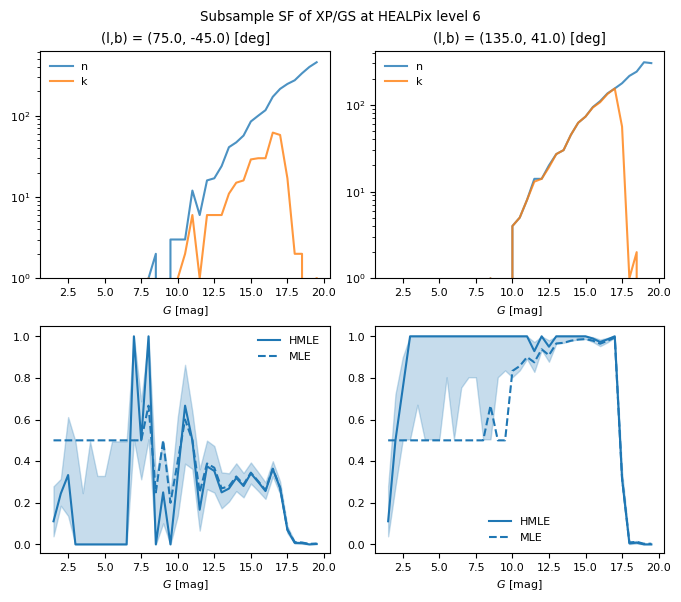

In [10]:
from scipy.special import expit, logit
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt


plt.rc('font', size=8.0)
inch = 2.54  ## cm
width, height = 17/inch, 15/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle(f"Subsample SF of XP/GS at HEALPix level {hplevel}")

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

l = [ 75, 135]
b = [-45,  41]
co = SkyCoord(l, b, frame='galactic', unit='deg')
healpix = HEALPix(nside=hp.order2nside(hplevel), order='nested', frame='icrs')
ipix = healpix.skycoord_to_healpix(co)
print("ipix:", ipix)

# The MLE Dataset
ds0 = subsampleSF.ds
# Augment the non-observed data with the non-informed estimate
p0 = expit(ds0['logitp'].fillna(logit(0.5)))
# NB: The MLD data is always at the highest healpix level,
# the one that was requested with the constructor of the `SubsampleSelectionFunction` class

# The HMLE Dataset at the required healpix level
# This dataset has the same structure as the MLE dataset, except the 'ci_lo' and 'ci_hi' fields
ds = subsampleSF_HMLE.hds[hplevel]
G = ds['phot_g_mean_mag_']
n = ds['n']
k = ds['k']
p = expit(ds['logitp'])
ci_lo = ds['ci_lo']
ci_hi = ds['ci_hi']

for i, hpx in enumerate(ipix):
    plt.subplot(2, 2, 1+i)
    plt.title(f"(l,b) = ({co[i].l.deg}, {co[i].b.deg}) [deg]")
    plt.plot(G, n[hpx], color=colors[0], alpha=0.8, label="n")
    plt.plot(G, k[hpx], color=colors[1], alpha=0.8, label="k")
    plt.legend(frameon=False)
    plt.xlabel("$G$ [mag]")
    plt.yscale('log')
    plt.ylim(ymin=1)

    plt.subplot(2, 2, 2+1+i)
    plt.plot(G, p[hpx], color=colors[0], label="HMLE")
    plt.plot(G, p0[hpx], '--', color=colors[0], label="MLE")
    plt.fill_between(G, ci_lo[hpx], ci_hi[hpx], color=colors[0], alpha=0.25)
    plt.legend(frameon=False)
    plt.xlabel("$G$ [mag]")
    plt.ylim(ymin=-0.04)

#plt.savefig(f"dr3_xp_hpx{hplevel}_twopix.pdf")
plt.show()
plt.close()

## Use case 5

Here, we fetch the same data with the `SubsampleSelectionFunction` class, then pass it to the new class as the `xarray.Dataset`. To inform the class with parameters of request, a dictionary of the parameters must be provided also.

This possibility, together with the compatibility with the `pandas.DataFrame` (the use case 4) is implemented for cases, if the user have their own parent catalogue and subsample. Please, explore the sources in order to understand how these things work.

In [ ]:
subsampleSF \
    = subsample.SubsampleSelectionFunction(subsample_query='has_xp_continuous', \
                                           file_name='dr3_xp_hpx6', hplevel_and_binning=inDict)

subsampleSF_HMLE = subsample.SubsampleSelectionFunctionHMLE().use(subsampleSF.ds, inDict, z=0.99)